# Analyse descriptives des données.

Réalisation d'analyses descriptives statistiques et graphiques sur différents jeux de données :

In [1]:
import glob, sys, sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#connection à la base de données (à la SGBD)
conn = sqlite3.connect('bdd.sqlite.db')

In [3]:
#Retourne une table de population de tous les pays
def population():
    SQL = 	''' select "Code Pays", Pays, Valeur as Population
from FAOSTAT_2013_population 
order by valeur desc;'''
    return pd.read_sql_query(SQL, con=conn)
#Affichage du tableau de population
print(population())

     Code Pays                      Pays  Population
0          351                     China     1416667
1           41           China, mainland     1385567
2          100                     India     1252140
3          231  United States of America      320051
4          101                 Indonesia      249866
..         ...                       ...         ...
170         83                  Kiribati         102
171          8       Antigua and Barbuda          90
172         55                  Dominica          72
173         17                   Bermuda          65
174        188     Saint Kitts and Nevis          54

[175 rows x 3 columns]


In [4]:
#Retourne une table de population mal nutrie pour tous les pays
def mal_nutrition():
    SQL = 	''' select "Code zone",
                        "zone",
                        Année,
                        "Unité", 
                        Valeur as "Population mal nutrie",
                        Symbole 
                from FAOSTAT_2013_sous_alimentation;'''
    return pd.read_sql_query(SQL, con=conn)
#Affichage d'une table de population mal nutrie pour tous les pays
print(mal_nutrition())

    "Code zone" "zone"      Année     Unité  Population mal nutrie Symbole
0     Code zone   zone  2012-2014  millions                    8.1       F
1     Code zone   zone  2012-2014  millions                    2.6       F
2     Code zone   zone  2012-2014  millions                    0.2       F
3     Code zone   zone  2012-2014  millions                    1.8       F
4     Code zone   zone  2012-2014  millions                    2.0      <2
..          ...    ...        ...       ...                    ...     ...
199   Code zone   zone  2012-2014  millions                    1.8       F
200   Code zone   zone  2012-2014  millions                   11.1       F
201   Code zone   zone  2012-2014  millions                    7.1       F
202   Code zone   zone  2012-2014  millions                    7.0       F
203   Code zone   zone  2012-2014  millions                    6.7       F

[204 rows x 6 columns]


Nous décidons de traier la malnutrition mondial par le prisme du pourcentage de malnutrition par pays.
Afin de symplifier les requêtes futures, nous créons une vue appelée "vue_pourcentage_pauverte.
Cette vue nous presente les données par ordre décroissant de % de malnutrition.

In [5]:
def create_view(connect):
    SQL =     ''' CREATE VIEW vue_pourcentage_pauverte AS
select  "Code groupe de pays partenaires" as Code_Group_Pays,
        "Groupe de pays partenaires" as Group_Pays, 
        "Code Pays" as Code_Pays,
        Pays, 
        Année, 
        val_pauvreté, 
        Symbole, 
        val_population, 
        percentage
from FAOSTAT_data INNER JOIN  ( -- vue de la jointure entre la table population et sous alimentation et calcul de la pauvreté
        select FAOSTAT_2013_population."Code Pays", 
            FAOSTAT_2013_population.Pays AS Pays, 
              FAOSTAT_2013_sous_alimentation.Année, 
              FAOSTAT_2013_sous_alimentation.Valeur as val_pauvreté,
            FAOSTAT_2013_sous_alimentation.Symbole,
            FAOSTAT_2013_population.Valeur as val_population,
            ((FAOSTAT_2013_sous_alimentation.Valeur/3)/(FAOSTAT_2013_population.Valeur/1000))*100 as percentage
        from FAOSTAT_2013_sous_alimentation INNER JOIN FAOSTAT_2013_population on FAOSTAT_2013_population."Code Pays" =FAOSTAT_2013_sous_alimentation."Code Pays"
    ) on "Code Pays" = FAOSTAT_data."Code pays partenaire" -- jointure pour integration du groupe de pays
where (FAOSTAT_data."Code groupe de pays partenaires" % 100)==0 and FAOSTAT_data."Code groupe de pays partenaires" != 5000
ORDER BY percentage DESC;'''
    
    try:
        #recupération de connection
        cursor = connect.cursor()
        print("Connected to the database")

        #execution de la requête et création de la table
        cursor.execute(SQL)
        connect.commit()
        print("Database created")
    except:
        pass

    #cloture de connection
    cursor.close()
    
    return 

#appel de la fonction de création de vue.
#resoit une connection à une SGBD
create_view(conn)

Connected to the database


On verifie que tout c'est bien passé.

In [6]:
#Retourne la vue concernant les poucentages de malnutrition pour tous les pays
def percentage():
    SQL = ''' select * from vue_pourcentage_pauverte ;'''
    return pd.read_sql_query(SQL, con=conn)
#affige de la vue
print(percentage())

     Code_Group_Pays Group_Pays  Code_Pays                      Pays  \
0               5100    Afrique         37  Central African Republic   
1               5200  Amériques         93                     Haiti   
2               5100    Afrique        251                    Zambia   
3               5100    Afrique        181                  Zimbabwe   
4               5100    Afrique         46                     Congo   
..               ...        ...        ...                       ...   
170             5500    Océanie         83                  Kiribati   
171             5500    Océanie        153             New Caledonia   
172             5500    Océanie         70          French Polynesia   
173             5500    Océanie        244                     Samoa   
174             5500    Océanie        155                   Vanuatu   

         Année  val_pauvreté Symbole  val_population  percentage  
0    2012-2014           2.1       F            4616   17.500000  
1

In [7]:
#Retourne la vue concernant les poucentages de malnutrition pour tous les pays
def percentage_grou_pays():
    
    SQL = ''' 
    select Group_Pays as Regions,
            count(Group_Pays) as nb_pays, 
            avg(percentage) as "Average % of poor nutrition"
    from vue_pourcentage_pauverte 
    group by Group_Pays;
    '''
    return pd.read_sql_query(SQL, con=conn)
#Affichage de la vue concernant les poucentages de malnutrition pour tous les pays
print(percentage_grou_pays())

     Regions  nb_pays  Average % of poor nutrition
0    Afrique       45                     7.789801
1  Amériques       36                     3.718958
2       Asie       46                     3.863341
3     Europe       39                     1.166149
4    Océanie        9                     0.851449


In [8]:
# Récupération de la liste des continents
def list_group_pays():
    SQL='''
    select DISTINCT Group_Pays from vue_pourcentage_pauverte
    '''
    return pd.read_sql_query(SQL, con=conn)
# Affichage de la liste des continents
print(list_group_pays())

  Group_Pays
0       Asie
1     Europe
2    Afrique
3    Océanie
4  Amériques


Analyse univarie
Histogramme de malnutrition par continant.

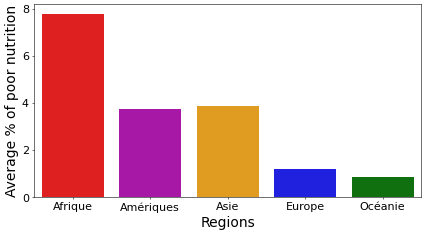

In [9]:
df=percentage_grou_pays()

fig,ax= plt.subplots(figsize=(10,5), dpi=50)
ax.set_xlabel('Average % of poor nutrition', fontsize = 20.0)
ax.set_ylabel('Regions', fontsize = 20.0)

colors=['red', 'm','orange', 'blue','green', 'gray']

sns.barplot(x = 'Regions'  , y =  "Average % of poor nutrition", data = df, palette = colors)
plt.tick_params(axis='both', which='major', labelsize=16)

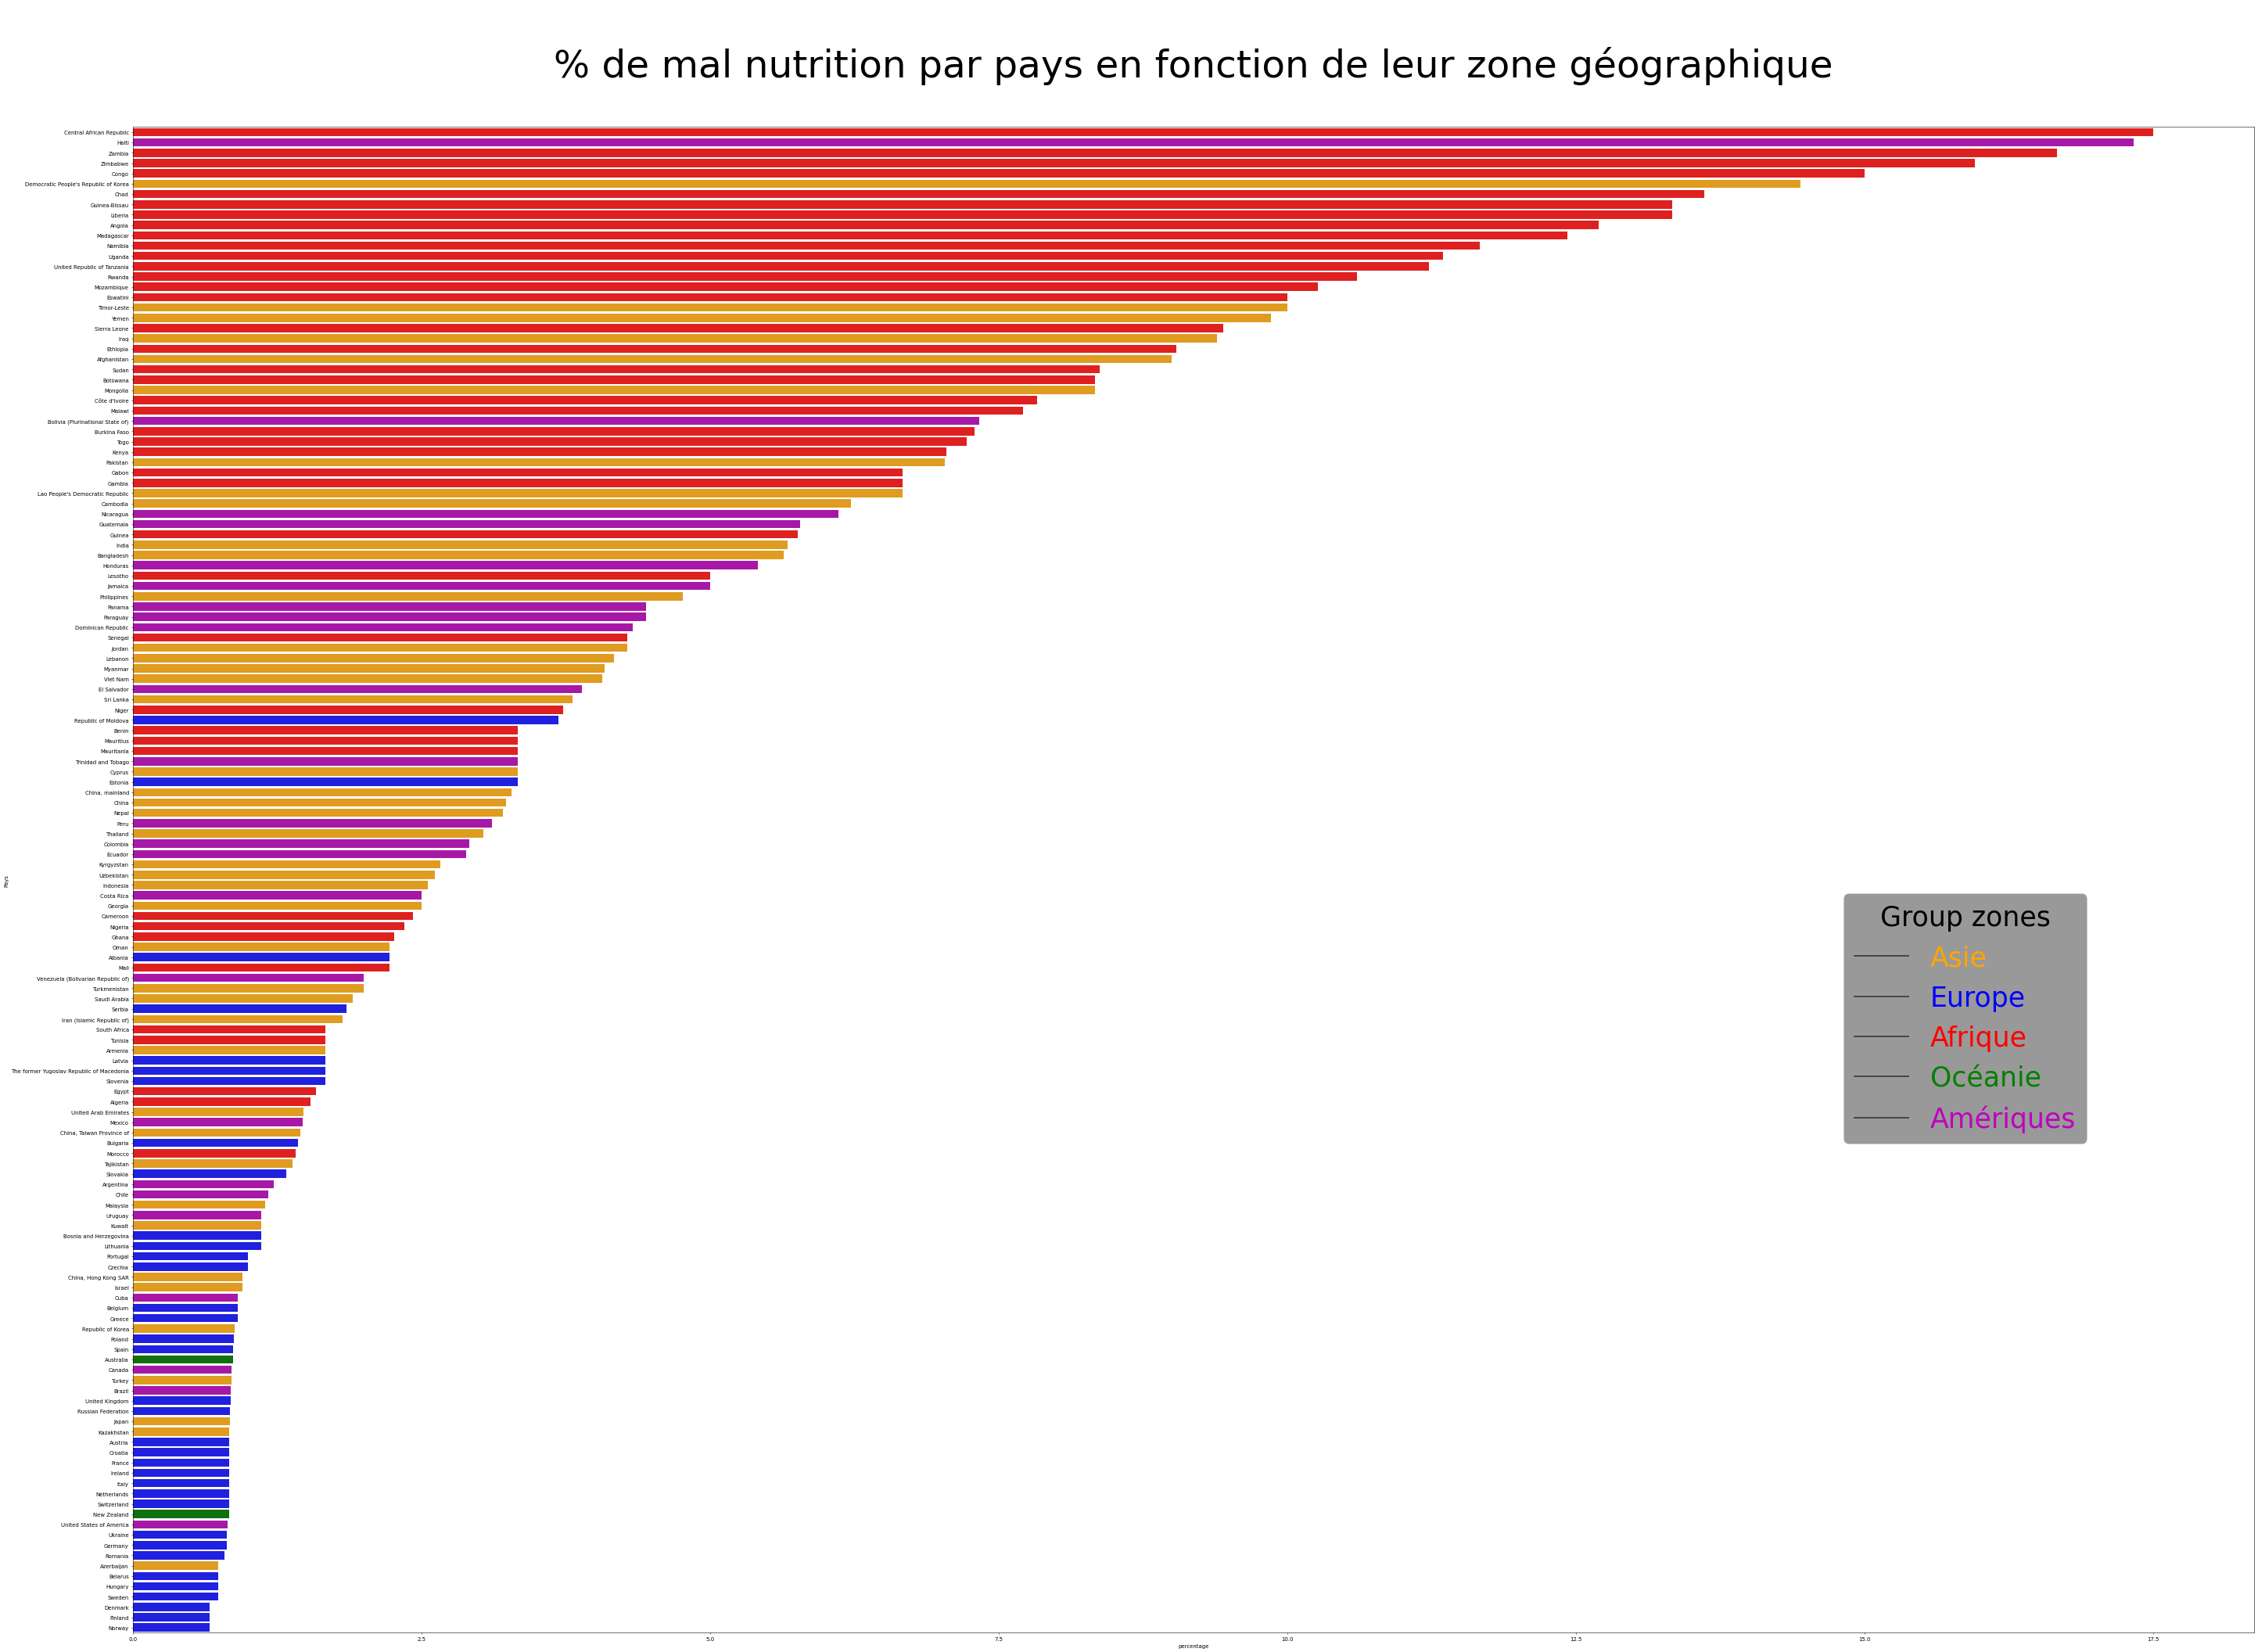

In [10]:
df=percentage()
df_grp_pays=list_group_pays()

labels=list_group_pays()["Group_Pays"]
colors=['orange', 'blue','red', 'green','m', 'gray']

pal=[]
for i in df.index:
    if df["Group_Pays"][i]=="Afrique":
        pal.append("red")
    elif df["Group_Pays"][i]=="Europe":
        pal.append("blue")
    elif df["Group_Pays"][i]=="Amériques":
        pal.append("m")
    elif df["Group_Pays"][i]=="Océanie":
        pal.append("green")
    elif df["Group_Pays"][i]=="Asie":
        pal.append("orange")
    else:
        pal.append("gray")

#paramétrage de la figure
fig,ax= plt.subplots(figsize=(70,50), dpi=50)
ax.set_xlabel('pays')
ax.set_ylabel('percentage')
df.dropna(how='any', inplace=True)
#tracé du bar graph de pourcentage
sns.barplot(x = 'percentage', y =  'Pays', data = df, palette = pal)
plt.legend( labels=labels, labelcolor  = colors, bbox_to_anchor=(0.8,0.5), loc=2,
           fontsize=50, facecolor="gray",
           title_fontsize=50, title="Group zones", markerscale=5)

plt.title("\n% de mal nutrition par pays en fonction de leur zone géographique\n", fontsize=70 );

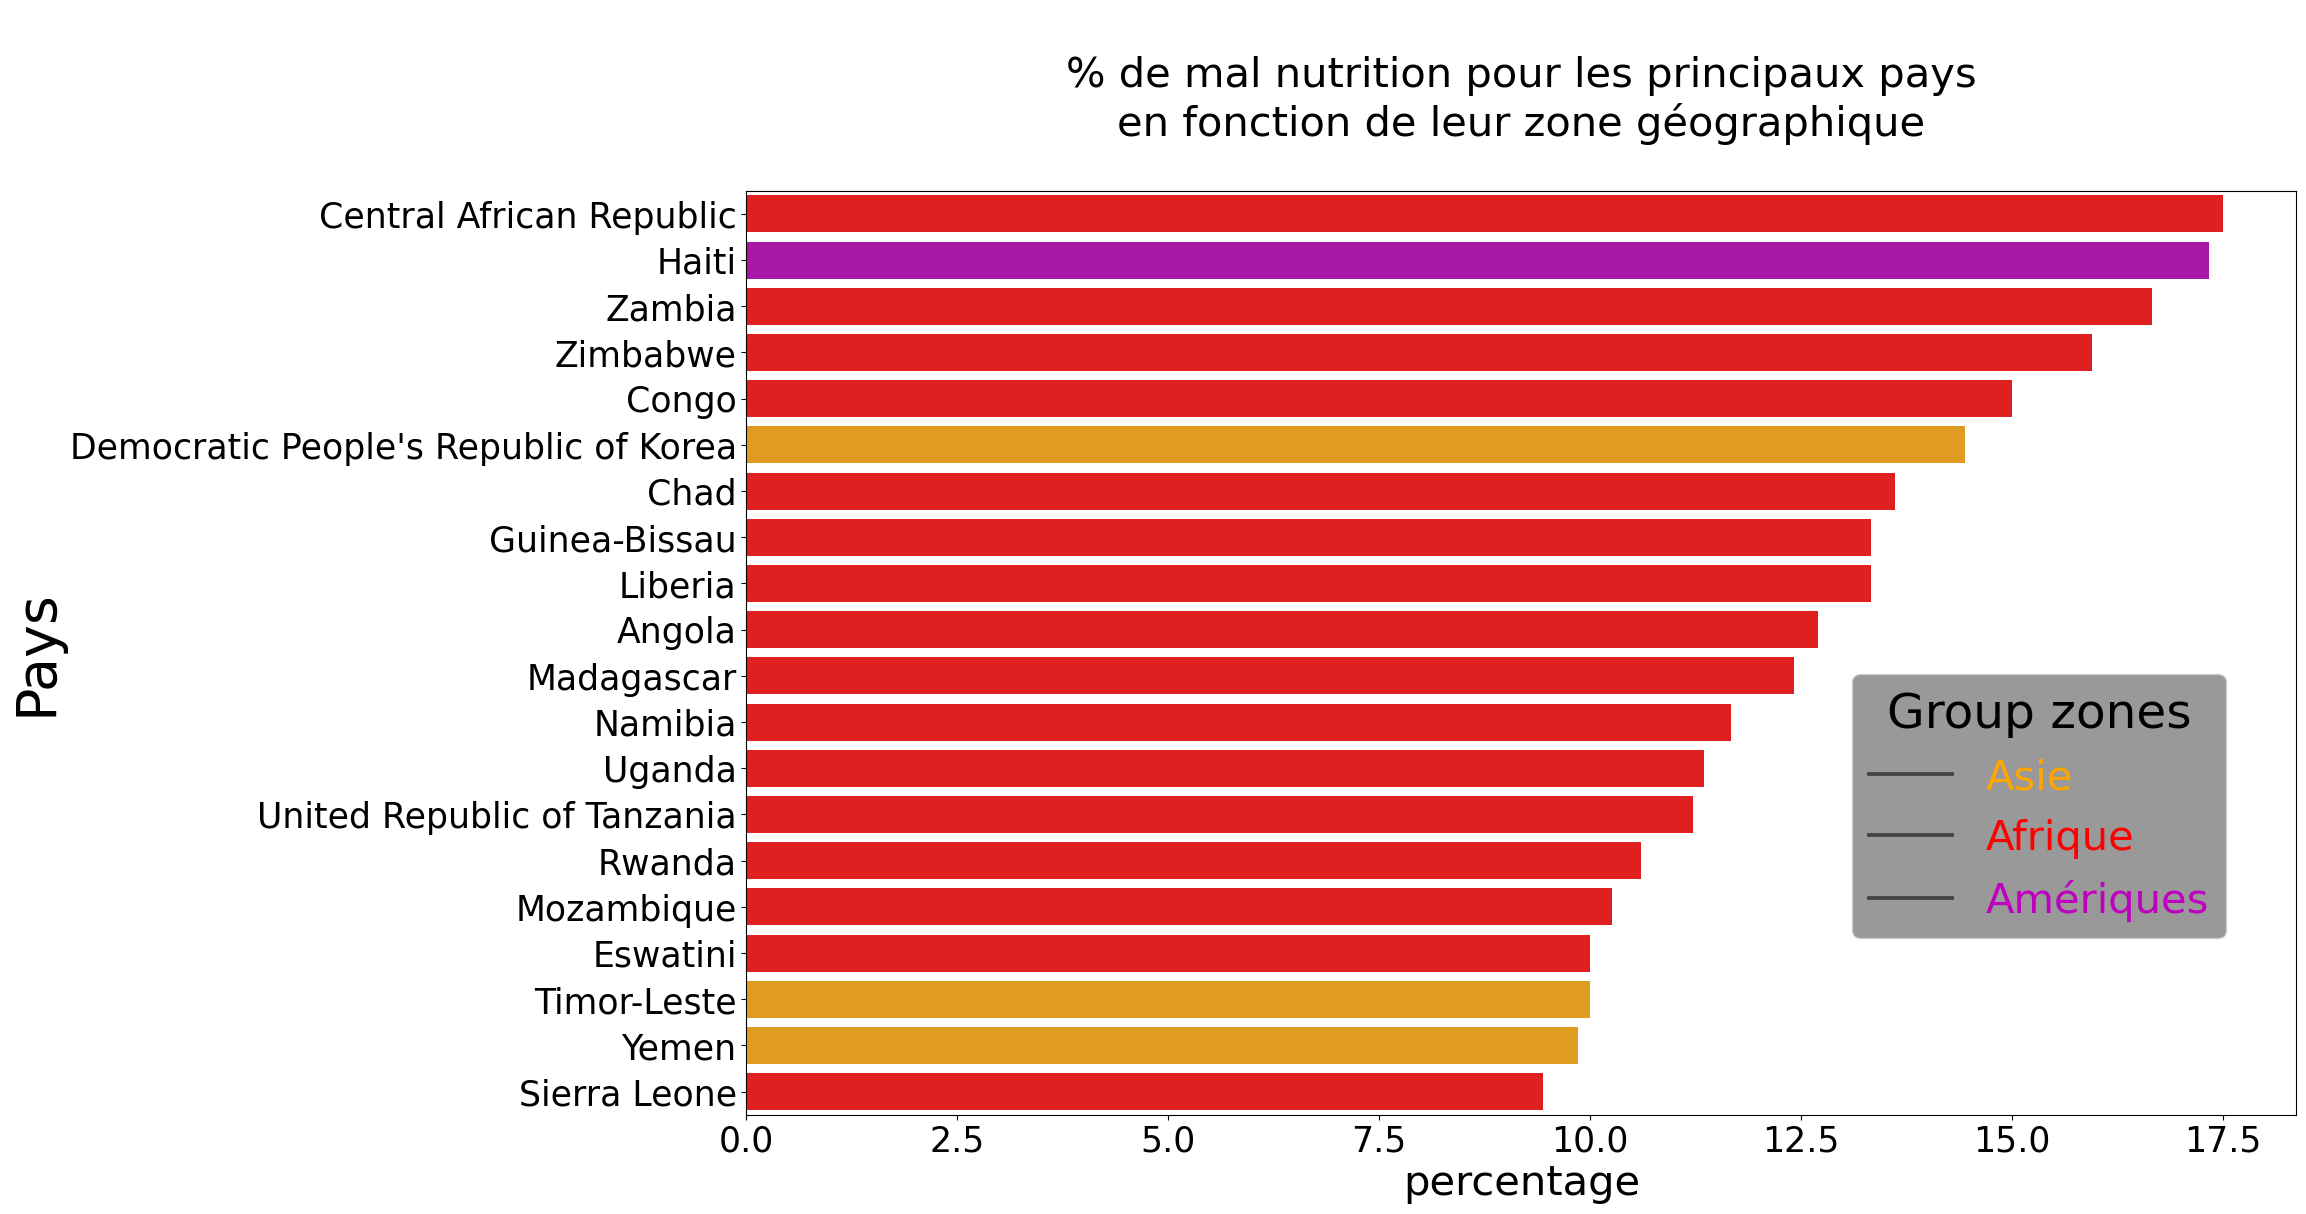

In [11]:
palette= "blend:#7AB,#EDA"
fig,ax= plt.subplots(figsize=(20,12), dpi=100)
ax.set_xlabel('pays', fontsize = 30.0)
ax.set_ylabel('percentage', fontsize = 40.0)
colors=['orange', 'red', 'm', 'gray']
try:
    del labels[1]
    del labels[3]
except:
    pass
# sns.barplot(x = 'percentage', y =  'Pays', data = df.head(20), palette = palette)
sns.barplot(x = 'percentage', y =  'Pays', data = df.head(20), palette = pal)
plt.legend( labels=labels, labelcolor  = colors, bbox_to_anchor=(0.7,0.5), loc=2,
           fontsize=30, facecolor="gray",
           title_fontsize=35, title="Group zones", markerscale=5)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.title("\n% de mal nutrition pour les principaux pays\nen fonction de leur zone géographique\n", fontsize=30 );

Exo : 2

Question 1 : Nombre d'humains sur la planète
Calculez le nombre total d’humains sur la planète.
Critiquez votre résultat. En cas d’anomalie, analysez et effectuer les corrections nécessaires.
Donnez le résultat de votre calcul pour l'année 2013.

In [ ]:
select sum(Valeur)*1000  from FAOSTAT_2013_population 
where "Code Pays" != 96 and "code Pays" != 128 and "code Pays" != 41 and "code Pays" != 214 

Question 2 : Redondances
Pour les datasets « animal », « cereal » et « vegetal », on considère ici les 11 quantités : Disponibilité
intérieure, Production, Importations, Variation, Exportations, Nourriture, Aliments, Animaux,
Semences, Pertes et Traitement.
Identifiez les redondances, en donnant votre réponse sous forme de formule mathématique (pas
besoin de coder ici).
C'est une équation à 3 termes de type (a_1 + a2 + [...] = b_1 + b_2 + [...] = c_1 + c_2 + [...]) ) faisant
intervenir chacune des 11 quantités données ci dessus.
Illustrez cette équation avec l'exemple du blé en France.

In [ ]:
select  *
from FAOSTAT_2013_cereal 
where (Pays IN ('France')) 
    AND ("Code Élément" > 1000) 
    AND (Produit IN ('Blé'))

Aliments pour animaux + Semences+Pertes+Traitement+Autres Utilisations+Nourriture = Disponibilité intérieure
7822+748+358+1575+2824+6971 = 20298
Production  + Importations  + Variation de stock -Exportations = Disponibilité intérieure
38614+2055+1131-21502=20298

Question 3 : Disponibilité alimentaire (calories, protéines)
Calculez (pour chaque pays et chaque produit) la disponibilité alimentaire en kcal par an puis en kg
de protéines par an. Vous ferez cela à partir de ces informations :
- Population de chaque pays
- Disponibilité alimentaire donnée pour chaque produit et pour chaque pays en kcal/personne/jour, -
- Disponibilité alimentaire en protéines donnée pour chaque produit et pour chaque pays en
g/personne/jour.

In [ ]:
select kcal.Pays, kcal.Produit,"kcal/kg" as Unité, kcal.Valeur/(prot.Valeur/1000)
from 
    (
    select Pays, Produit, Valeur 
    from vue_2013_disp_Kcal_prot
    where Élément = "Disponibilité alimentaire (Kcal/personne/jour)"
    ) as kcal,
    (
    select Pays, Produit, Valeur 
    from vue_2013_disp_Kcal_prot
    where Élément = "Disponibilité de protéines en quantité (g/personne/jour)"
    ) as prot
where kcal.Pays=prot.Pays and kcal.Produit=prot.Produit

Question 4 : Ratio énergie/poids
A partir de ces dernières informations, et à partir du poids de la disponibilité alimentaire (pour
chaque pays et chaque produit), calculez pour chaque produit le ratio "énergie/poids", que vous

donnerez en kcal/kg. Vous pouvez vérifier la cohérence de votre calcul en comparant ce ratio aux
données disponibles sur internet, par exemple en cherchant la valeur calorique d'un oeuf.

In [ ]:
select * FROM
(
    select kcal.Pays,
            kcal.Produit,
            "kcal/kg" as Unité, 
            ROUND(kcal.Calorie/(prot.Proteine/1000)) as Ratio_Cal_Prot,
            kcal.Calorie as Calorie,
            prot.Proteine as Proteine
    from 
        (
        select Pays, Produit, Valeur as Calorie
        from vue_2013_disp_Kcal_prot
        where Élément = "Disponibilité alimentaire (Kcal/personne/jour)"
        ) as kcal,
        (
        select Pays, Produit, Valeur as Proteine
        from vue_2013_disp_Kcal_prot
        where Élément = "Disponibilité de protéines en quantité (g/personne/jour)"
        ) as prot
    where kcal.Pays=prot.Pays and kcal.Produit=prot.Produit
    
    order by Ratio_Cal_Prot DESC limit 20
)
ORDER BY Calorie desc limit 5

In [ ]:
select * FROM
(
    select kcal.Pays,
            kcal.Produit,
            "kcal/kg" as Unité, 
            ROUND(kcal.Calorie/(prot.Proteine/1000)) as Ratio_Cal_Prot,
            kcal.Calorie as Calorie,
            prot.Proteine as Proteine
    from 
        (
        select Pays, Produit, Valeur as Calorie
        from vue_2013_disp_Kcal_prot
        where Élément = "Disponibilité alimentaire (Kcal/personne/jour)"
        ) as kcal,
        (
        select Pays, Produit, Valeur as Proteine
        from vue_2013_disp_Kcal_prot
        where Élément = "Disponibilité de protéines en quantité (g/personne/jour)"
        ) as prot
    where kcal.Pays=prot.Pays and kcal.Produit=prot.Produit
    
    order by Ratio_Cal_Prot DESC limit 20
)
ORDER BY Proteine desc limit 5

Question 6 : Dispo. intérieure mondiale des végétaux
Calculez, pour les produits végétaux uniquement, la disponibilité intérieure mondiale exprimée en
kcal.

In [ ]:
select sum("Disp interieur" * "Calories"*1000), "KCal" as "Unité"
FROM (
    select Pays, Produit, Valeur as "Disp interieur"
    from FAOSTAT_2013_vegetal
    where FAOSTAT_2013_vegetal."Code Élément" = 5301
    ) AS table_disp,
    (
    select Pays, Produit, Valeur as "Calories"
    from FAOSTAT_2013_vegetal
    where "Code Élément" = 645
    ) AS table_calories
where table_disp.Pays=table_calories.Pays and table_disp.Produit=table_calories.Produit

Question 7 : Potentiel alimentaire des végétaux
Combien d'humains pourraient être nourris si toute la disponibilité intérieure mondiale de produits
végétaux était utilisée pour de la nourriture ? Donnez les résultats en termes de calories, puis de
protéines, et exprimez ensuite ces 2 résultats en pourcentage de la population mondiale.

reponce de chatGPT a la question "quel est le besoin moyen en calorie pour les humains" 
Le besoin en calories varie considérablement d'une personne à l'autre en fonction de facteurs tels que l'âge, le sexe, la taille, le poids, le niveau d'activité physique et d'autres considérations de santé. En général, les adultes ont besoin d'environ 2000 à 2500 calories par jour pour maintenir leur poids corporel, mais cela peut varier de 1200 à plus de 3000 calories par jour en fonction des besoins individuels.


In [ ]:
select "Disponibilité Mondial (Kcal)", round("Disponibilité Mondial (Kcal)"/2.500) as "Nombre d'individues peut nourrir" from
    (select sum("Disp interieur" * "Calories"*1000) as "Disponibilité Mondial (Kcal)"
    FROM (
        select Pays, Produit, Valeur as "Disp interieur"
        from FAOSTAT_2013_vegetal
        where FAOSTAT_2013_vegetal."Code Élément" = 5301
        ) AS table_disp,
        (
        select Pays, Produit, Valeur as "Calories"
        from FAOSTAT_2013_vegetal
        where "Code Élément" = 645
        ) AS table_calories
    where table_disp.Pays=table_calories.Pays and table_disp.Produit=table_calories.Produit) as mondial

Question 8 : Potentiel alimentaire des végétaux (destinés aux animaux pertes)
Combien d'humains pourraient être nourris si toute la disponibilité alimentaire en produits végétaux
la nourriture végétale destinée aux animaux et les pertes de produits végétaux étaient utilisés pour
de la nourriture ? Donnez les résultats en termes de calories, puis de protéines, et exprimez ensuite
ces 2 résultats en pourcentage de la population mondiale.

Le besoin en protéines varie également d'une personne à l'autre en fonction de facteurs tels que l'âge, le sexe, la taille, le poids, le niveau d'activité physique et d'autres considérations de santé.

En général, l'Organisation Mondiale de la Santé (OMS) recommande une consommation quotidienne de 0,8 gramme de protéines par kilogramme de poids corporel pour les adultes en bonne santé. Cela signifie qu'une personne pesant 60 kg a besoin d'environ 48 grammes de protéines par jour.

Cependant, pour les athlètes et les personnes qui font des entraînements intenses, le besoin en protéines peut être plus élevé, jusqu'à 1,6 à 1,7 gramme de protéines par kilogramme de poids corporel par jour. Il est important de souligner que les besoins en protéines sont également plus élevés chez les personnes qui perdent du poids, chez les femmes enceintes et allaitantes, et chez les personnes âgées.

Il est important de noter qu'il est possible d'obtenir suffisamment de protéines en consommant une variété d'aliments, tels que les viandes, les volailles, les poissons, les œufs, les légumineuses, les noix et les graines. Il est recommandé de consommer des aliments riches en protéines tout au long de la journée pour répartir les apports.

Il est toujours important de consulter un professionnel de santé pour établir les besoins en protéines appropriés pour vous.
-------------------------------------------------------------------------------------------------------------------------------
Le poids moyen d'un adulte varie considérablement en fonction de nombreux facteurs, notamment l'âge, le sexe, la taille, l'activité physique, la génétique et l'alimentation. Il est difficile de donner un poids moyen précis pour tous les adultes, mais en général, le poids moyen d'un adulte varie entre 50 et 90 kg.

Pour les hommes, le poids moyen est généralement légèrement supérieur à celui des femmes. Selon les données de l'Organisation mondiale de la santé (OMS), le poids moyen pour les hommes adultes est d'environ 80 kg, tandis que pour les femmes adultes, il est d'environ 70 kg.

Il est important de noter que le poids ne doit pas être considéré comme le seul indicateur de la santé d'une personne. Il existe de nombreux autres facteurs importants, tels que l'IMC (indice de masse corporelle), la composition corporelle et la santé globale, qui doivent être pris en compte pour évaluer la santé d'une personne.

Il est important de rappeler que pour évaluer notre poids il est important de consulter des professionnels de la santé qui pourraient nous aider à définir des objectifs de poids réaliste et sain et pour éviter toute pathologie liée à un poids excessive ou insuffisant.